In [1]:
from datasets import load_dataset
import torch 
dataset = load_dataset("lj_speech", split="train")

In [2]:
print(dataset)

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 13100
})


In [3]:
from datasets import load_dataset, Audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [4]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
tokenizer = processor.tokenizer

In [6]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [7]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'â', 'è', 'ü', '’', '“', '”'}

In [8]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

In [9]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]


    return example

processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels']

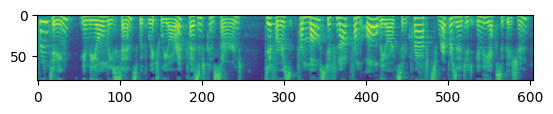

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [11]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [12]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/13100 [00:00<?, ? examples/s]

13100

In [13]:
dataset = dataset.train_test_split(test_size=0.1)

In [14]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]


        return batch

In [15]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [16]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

model.config.use_cache = False

from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_ljspeech",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
)

from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()

wandb: Currently logged in as: thejosephloy. Use `wandb login --relogin` to force relogin


/home/thejoey/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.785500,0.728188
2000,0.678900,0.603808
3000,0.641400,0.551176
4000,0.635300,0.534461


/home/thejoey/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/thejoey/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/thejoey/.local/lib/python3.10/site-packages/torch/utils/checkpoi

TrainOutput(global_step=4000, training_loss=0.7680847873687744, metrics={'train_runtime': 5613.3809, 'train_samples_per_second': 22.803, 'train_steps_per_second': 0.713, 'total_flos': 1.5086924014932e+16, 'train_loss': 0.7680847873687744, 'epoch': 10.85})

In [19]:
from transformers import pipeline

pipe = pipeline("text-to-speech", model="speecht5_ljspeech/checkpoint-4000")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [35]:
text = "Does Balboni run this shit?"

In [36]:
output = pipe(text)

In [37]:
from IPython.display import Audio
Audio(output['audio'], rate=output['sampling_rate']) 